# Sparse Portfolio Stat Arb with Ornstein Uhlenbeck Spread Calculation

### Equity Stat Arb Strategy

At a super high level, this strat involves finding a bunch of stocks from the same sector, calculating weights to create a mean reverting portfolio, then trading the spread of that portfolio.

Steps:

1. **Asset Universe Selection**  
   Select a basket of N correlated equities (e.g., 50 stocks from the same sector in the S&P 500). This maximizes the chance of finding stationary relationships in the price data.

2. **Data Collection**  
   Collect intraday historical OHLCV data (e.g., 1h bars) for the selected tickers. Use log prices as the input for portfolio construction and spread modeling.

3. **Create Sparse Mean Reverting Portfolio**  
   Solve a convex optimization problem that finds a sparse weight vector `w` that minimizes the OU negative log-likelihood of the spread `X_t = w^T * log(P_t)`, subject to an L1 penalty on `w`.  
   - **Input**: Log price matrix of shape `(T, N)`  
   - **Output**: Sparse portfolio weights `w` of length `N`

4. **Fit an OU Model to the Spread**  
   Model the spread `X_t` using a discrete-time Ornstein-Uhlenbeck process:  
   `X_{t+1} = mu + (1 - theta) * (X_t - mu) + epsilon_t`, where `epsilon_t ~ N(0, sigma^2)`  
   Estimate OU parameters `(mu, theta, sigma)` using maximum likelihood estimation.  
   - **Input**: Spread time series `X_t`  
   - **Output**: OU parameters `mu`, `theta`, and `sigma`

5. **Per Tick: Compute Spread, Compute Z-score, Generate Signals**  
   For each new price observation:  
   - Recompute `X_t = w^T * log(P_t)`  
   - Compute z-score from OU model:  
     `Z_t = (X_t - mu) / (sigma / sqrt(2 * theta))`  
   - Generate trading signals:  
     - **Long** if `Z_t < -entry_threshold`  
     - **Short** if `Z_t > entry_threshold`  
     - **Exit** if `|Z_t| < exit_threshold`  
   - **Output**: Signal object with position direction and notional weights


In [2]:
import pandas as pd
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.enums import Adjustment
from alpaca.data.timeframe import TimeFrame
from typing import List

api_key: str = "AKUC33GDKW6S5UD6K74T"
api_secret: str = "oP507MmhcMabZ5puUoyXOxTp50XC3NjqTTv7Adcm"

def get_bars(
    symbols: List[str],
    start_date: str,
    end_date: str,
    frequency: str = "1d"
) -> pd.DataFrame:
    freq_map = {
        "1m": TimeFrame.Minute,
        "5m": TimeFrame(5, TimeFrame.Minute),
        "15m": TimeFrame(15, TimeFrame.Minute),
        "1h": TimeFrame.Hour,
        "1d": TimeFrame.Day
    }

    timeframe = freq_map.get(frequency)
    if not timeframe:
        raise ValueError(f"Unsupported frequency: {frequency}")

    client = StockHistoricalDataClient(api_key, api_secret)

    request = StockBarsRequest(
        symbol_or_symbols=symbols,
        start=pd.to_datetime(start_date),
        end=pd.to_datetime(end_date),
        timeframe=timeframe,
        adjustment=Adjustment.ALL
    )

    barset = client.get_stock_bars(request).df
    if not isinstance(barset, pd.DataFrame) or barset.empty:
        print(f"[Alpaca] Empty equity data for: {symbols}")
        return pd.DataFrame()

    # barset["timestamp"] = pd.to_datetime(barset["timestamp"]).dt.tz_localize(None)
    # barset.set_index("timestamp", inplace=True)

    return barset.reset_index()

In [3]:
import numpy as np

def make_log_price_matrix(raw_df, symbol_col=0, time_col=1, price_col=-1):
    """
    Convert raw tick-level data into a log-price matrix of shape (T, N),
    where T = timestamps, N = number of tickers.

    Parameters:
    - raw_df: DataFrame or list of lists
    - symbol_col: index of the column containing the ticker
    - time_col: index of the timestamp column
    - price_col: index of the price column to use (e.g., close or VWAP)

    Returns:
    - log_price_matrix: DataFrame with datetime index and ticker columns
    """

    # Convert to DataFrame if needed
    if not isinstance(raw_df, pd.DataFrame):
        df = pd.DataFrame(raw_df)
    else:
        df = raw_df.copy()

    df.columns = df.columns.astype(str)

    # Parse relevant columns
    df['symbol'] = df.iloc[:, symbol_col]
    df['timestamp'] = pd.to_datetime(df.iloc[:, time_col])
    df['price'] = pd.to_numeric(df.iloc[:, price_col], errors='coerce')

    df_agg = df.groupby(['timestamp', 'symbol'])['price'].mean().reset_index()
    price_matrix = df_agg.pivot(index='timestamp', columns='symbol', values='price')

    # Drop any timestamps with missing prices for any symbol (optional)
    price_matrix = price_matrix.dropna()

    # Take log prices
    log_price_matrix = np.log(price_matrix)

    return log_price_matrix

In [4]:
import cvxpy as cp
import numpy as np



symbols = ['AAPL','GOOG','MSFT','NVDA','META']

prices = get_bars(symbols, '2025-04-10','2025-04-17','1m')

log_prices = make_log_price_matrix(prices)
print(log_prices)





symbol                         AAPL      GOOG      META      MSFT      NVDA
timestamp                                                                  
2025-04-10 08:00:00+00:00  5.270498  5.066298  6.346638  5.954878  4.713476
2025-04-10 08:03:00+00:00  5.267422  5.063923  6.350196  5.947778  4.711944
2025-04-10 08:07:00+00:00  5.272435  5.065187  6.350734  5.950643  4.710945
2025-04-10 08:11:00+00:00  5.269310  5.064359  6.346355  5.948822  4.709045
2025-04-10 08:12:00+00:00  5.269230  5.062595  6.345654  5.947871  4.707915
...                             ...       ...       ...       ...       ...
2025-04-16 20:54:00+00:00  5.270175  5.049151  6.217667  5.918751  4.637999
2025-04-16 21:01:00+00:00  5.271434  5.047355  6.218664  5.918402  4.635911
2025-04-16 23:06:00+00:00  5.270818  5.046967  6.220292  5.918333  4.642479
2025-04-16 23:24:00+00:00  5.273556  5.051009  6.220491  5.920935  4.641204
2025-04-16 23:44:00+00:00  5.272122  5.050241  6.219198  5.920586  4.640019

[2416 rows 

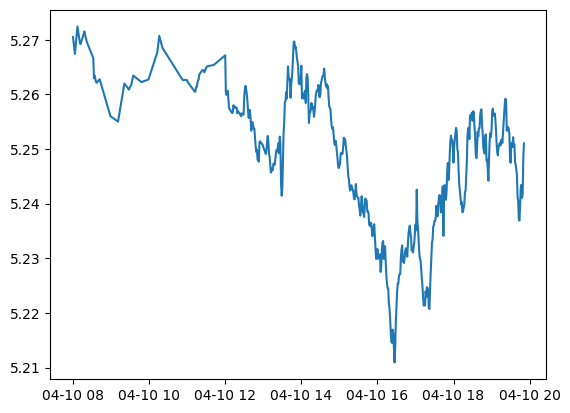

In [11]:
import matplotlib.pyplot as plt

plt.plot(log_prices['AAPL'][:500])
plt.show()


In [ ]:
import cvxpy as cp
import numpy as np

# Convert log_prices to numpy if it's not already
log_prices_np = log_prices.to_numpy() if hasattr(log_prices, 'to_numpy') else log_prices

T, N = log_prices_np.shape

# Step 1: Find a sparse portfolio first using a different approach
# We'll use a two-stage approach where we first find portfolio weights
# Then fit the OU process to the resulting spread

# Create a covariance matrix of log returns
returns = np.diff(log_prices_np, axis=0)
cov_matrix = np.cov(returns.T)

# Set up the portfolio weight optimization problem
w = cp.Variable(N)
objective = cp.Minimize(cp.quad_form(w, cov_matrix) + 0.00001 * cp.norm1(w))

# Constraints - dollar neutral and unit norm
constraints = [
    cp.sum(w) == 0,  # Dollar-neutral constraint
    cp.norm(w, 2) <= 1  # Ensure weights aren't too large
]

# Solve for portfolio weights
problem = cp.Problem(objective, constraints)
problem.solve()

# Extract the optimized weights
w_opt = w.value

# Step 2: Compute the spread time series using these weights
spread = log_prices_np @ w_opt

# Step 3: Fit an AR(1) model to the spread time series
X_t = spread[:-1]
X_t1 = spread[1:]
A = np.vstack([X_t, np.ones(len(X_t))]).T
phi_hat, c_hat = np.linalg.lstsq(A, X_t1, rcond=None)[0]

# Convert AR(1) parameters to OU parameters
theta_hat = 1 - phi_hat
mu_hat = c_hat / theta_hat if theta_hat != 0 else 0.0
residuals = X_t1 - (phi_hat * X_t + c_hat)
sigma_hat = np.std(residuals)

print("Optimization status:", problem.status)
print("Sparse weights w:", w_opt)
print("OU parameters:")
print("  mu =", mu_hat)
print("  theta =", theta_hat)
print("  sigma =", sigma_hat)

Optimization status: optimal
Sparse weights w: [0. 0. 0. 0. 0.]
OU parameters:
  mu = 0.0
  theta = 1.0
  sigma = 0.0


In [56]:
# Check for data issues
import numpy as np

# Calculate returns
returns = np.diff(log_prices_np, axis=0)

# 1. Check for basic statistics of log prices
print("Basic log price stats:")
print("Mean:", np.mean(log_prices_np, axis=0))
print("Std:", np.std(log_prices_np, axis=0))
print("Min:", np.min(log_prices_np, axis=0))
print("Max:", np.max(log_prices_np, axis=0))
print()

# 2. Look at return statistics
print("Return stats:")
print("Mean returns:", np.mean(returns, axis=0))
print("Std returns:", np.std(returns, axis=0))
print("Min returns:", np.min(returns, axis=0))
print("Max returns:", np.max(returns, axis=0))
print()

# 3. Check correlations between stocks
corr_matrix = np.corrcoef(log_prices_np.T)
print("Correlation matrix:")
print(corr_matrix)
print()

# 4. Check stationarity of individual log prices
from statsmodels.tsa.stattools import adfuller

print("Stationarity tests (ADF) for log prices:")
for i, symbol in enumerate(log_prices.columns if hasattr(log_prices, 'columns') else range(log_prices_np.shape[1])):
    result = adfuller(log_prices_np[:, i])
    print(f"{symbol}: p-value = {result[1]:.4f} ({'Stationary' if result[1] < 0.05 else 'Non-stationary'})")

print("\nStationarity tests (ADF) for returns:")
for i, symbol in enumerate(log_prices.columns if hasattr(log_prices, 'columns') else range(log_prices_np.shape[1])):
    result = adfuller(returns[:, i])
    print(f"{symbol}: p-value = {result[1]:.4f} ({'Stationary' if result[1] < 0.05 else 'Non-stationary'})")

Basic log price stats:
Mean: [5.28621424 5.06497041 6.28065109 5.94886021 4.69136563]
Std: [0.03068512 0.01517031 0.0340775  0.01550704 0.03028625]
Min: [5.21092765 5.02686758 6.20666966 5.90926997 4.61108101]
Max: [5.35853254 5.09963237 6.36086169 5.97752486 4.74764494]

Return stats:
Mean returns: [ 6.72354556e-07 -6.64923259e-06 -5.27704802e-05 -1.41997475e-05
 -3.04170247e-05]
Std returns: [0.00205382 0.00119408 0.00153682 0.00111653 0.00207079]
Min returns: [-0.01267833 -0.00843794 -0.0090224  -0.00744485 -0.03189822]
Max returns: [0.06537721 0.01468463 0.01645375 0.01264221 0.03452093]

Correlation matrix:
[[ 1.          0.81394681 -0.18313629  0.72661876  0.59008153]
 [ 0.81394681  1.          0.27175629  0.8776279   0.75974028]
 [-0.18313629  0.27175629  1.          0.3914895   0.53877089]
 [ 0.72661876  0.8776279   0.3914895   1.          0.88734973]
 [ 0.59008153  0.75974028  0.53877089  0.88734973  1.        ]]

Stationarity tests (ADF) for log prices:
0: p-value = 0.4558 (N